# Check start and end of segments in all samples

We noticed that the segments length can vary from sample to sample, even on only one machine. The goal of this notebook is to compute the indices of all the segments in order to compare them

In [2]:
import os
from pathlib import Path
import sys
import pandas as pd
from matplotlib import pyplot as plt


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from utils.detectConstantSegments import detectConstantSegments

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Retrieve all sample names

In [11]:
dataPath: Path = "../../data/normalized-2025_05_08/"

path = os.path.join(current_folder, dataPath)

sampleNames = os.listdir(path)

print("Sample names: ", sampleNames)

indices = pd.DataFrame()

for sampleName in sampleNames:
    print("Processing sample: ", sampleName)

    samplePath = os.path.join(path, sampleName)

    # Load the data
    df = pd.read_parquet(samplePath)
    print("Data shape: ", df.shape)

    # check that stSigSpindleVelocity' is in the columns
    if 'stSigSpindleVelocity' not in df.columns:
        print("Sample" + sampleName + " does not contain stSigSpindleVelocity")
        continue

    # Detect constant segments
    segmentsIndices = detectConstantSegments(df)

    if len(segmentsIndices) != 6:
        print("Sample " + sampleName + " does not contain 6 segments")
        continue

    # Add the sample name to the indices
    indices[sampleName.split(".")[0]] = segmentsIndices
   
print(indices)


Sample names:  ['Mecatis_10_03_25.parquet', 'Locle_2025_03_18.parquet', 'Mecatis_10_03_25_4.parquet', 'Mecatis_10_03_25_5.parquet', 'Mecatis_24_03_25.parquet', 'Mecatis_05_02_25.parquet', 'MILL_13-03-2025_7h35.parquet', 'Mecatis_10_03_25_3.parquet', 'MILL_13-03-2025_10h35.parquet', 'Mecatis_20_01_25_AV_chang_Axe_X.parquet', 'Mecatis_17_02_25.parquet', 'Locle_2025_03_20.parquet', 'Mecatis_03_02_25.parquet', 'MILL_19-02-2025_9h20.parquet', 'Mecatis_10_03_25_2.parquet', 'Mecatis_20_01_25_apres_chgt_AxeX.parquet']
Processing sample:  Mecatis_10_03_25.parquet
Data shape:  (2065450, 75)
Processing sample:  Locle_2025_03_18.parquet
Data shape:  (1716539, 62)
SampleLocle_2025_03_18.parquet does not contain stSigSpindleVelocity
Processing sample:  Mecatis_10_03_25_4.parquet
Data shape:  (2065441, 75)
Processing sample:  Mecatis_10_03_25_5.parquet
Data shape:  (2065426, 75)
Processing sample:  Mecatis_24_03_25.parquet
Data shape:  (912552, 75)
SampleMecatis_24_03_25.parquet does not contain 6 se

## Compute segments lengths

In [19]:
segmentsLengths = pd.DataFrame(columns=indices.columns)
for i in range(len(indices.columns)):
    # subtract first element of tuples from the second
    segmentsLengths.iloc[:, i] = indices.iloc[:, i].apply(lambda x: x[1] - x[0])


print(segmentsLengths)

# subtract length of a reference sample from the other samples
referenceSample = "Mecatis_03_02_25"

relativeLengths = pd.DataFrame(columns=segmentsLengths.columns)
for i in range(len(segmentsLengths.columns)):
    relativeLengths.iloc[:, i] = segmentsLengths.iloc[:, i] - segmentsLengths.loc[:,referenceSample]

# print(relativeLengths)


   Mecatis_10_03_25 Mecatis_10_03_25_4 Mecatis_10_03_25_5 Mecatis_05_02_25  \
0             83191              83182              83190            83190   
1             80563              80565              80553            80568   
2            528400             528396             528394           528407   
3             77018              77019              77009            77019   
4            115710             115710             115713           115714   
5           1175298            1175298            1175294          1175294   

  Mecatis_10_03_25_3 Mecatis_17_02_25 Mecatis_03_02_25 Mecatis_10_03_25_2  \
0              83190            83179            83180              83197   
1              80564            80564            80549              80564   
2             528403           528407           528394             528406   
3              77009            77007            77005              77020   
4             115710           115713           115703             1

# Plot relative lengths

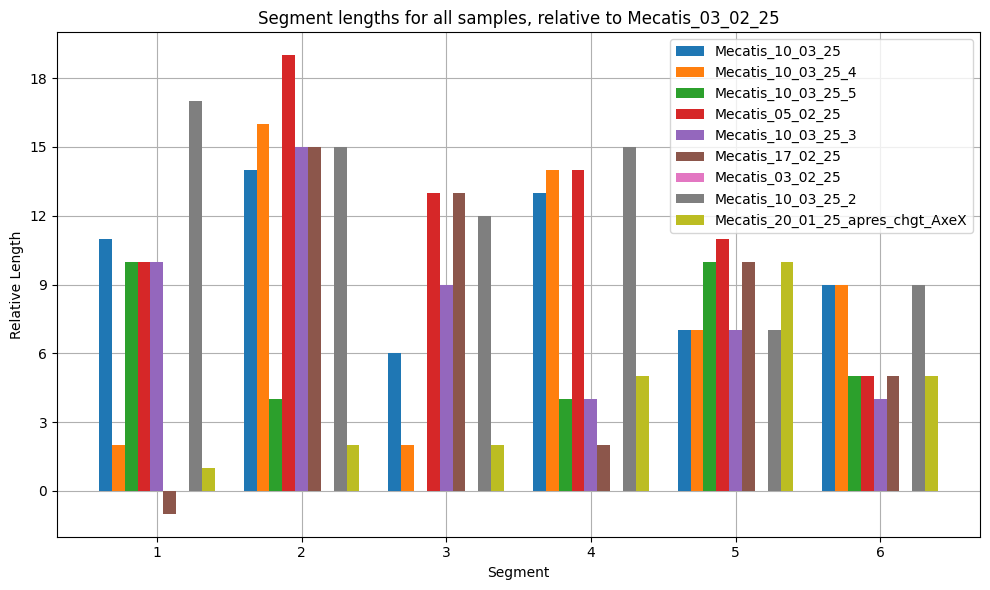

In [26]:
import numpy as np
from matplotlib.ticker import MaxNLocator

n_segments = relativeLengths.shape[0]
n_samples = relativeLengths.shape[1]
bar_width = 0.8 / n_samples  # Make bars fit nicely

x = np.arange(n_segments)  # one position per segment

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.set_axisbelow(True)  # This sends the grid behind the bars
plt.grid()

for i, sample in enumerate(relativeLengths.columns):
    plt.bar(x + i * bar_width, relativeLengths.iloc[:, i], width=bar_width, label=sample)

plt.xlabel("Segment")
plt.ylabel("Relative Length")
plt.title("Segment lengths for all samples, relative to " + referenceSample)
plt.xticks(x + bar_width * (n_samples - 1) / 2, [i+1 for i in x])
plt.legend()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # <-- Only integer ticks
plt.tight_layout()
plt.show()

